# A demonstration of oslo_method_python


Before this notebook is run on a new system, make sure to compile the Cython files by doing (in the top repo directory):

```python setup.py build_ext --inplace```

In [1]:
%load_ext autoreload
import matplotlib.pyplot as plt
import numpy as np
import ompy as om
import logging
%autoreload 2
%matplotlib notebook

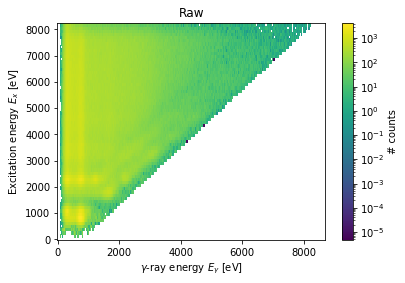

In [2]:
# Import raw matrix into instance of om.Matrix() and plot it
raw = om.load_example_raw('Dy164')
raw.cut_diagonal((800, 0), (7500, 7300))
raw.cut(axis='Ex', limits=[0, 8400])
raw.plot()

  warnings.warn("Hello from the fill_negative() function. Please debug me.")



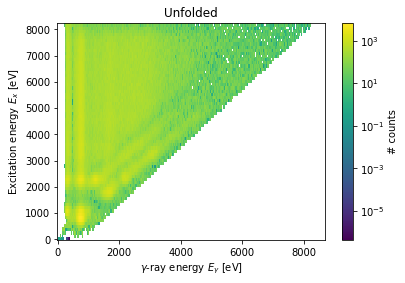

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("ompy.unfolder")
logger.setLevel(logging.INFO)

fname_resp_mat = "../data/Dy164_response_matrix.m"
fname_resp_dat = "../data/Dy164_response_parameters.dat"

unfolder = om.Unfolder()
unfolder.load_response(fname_resp_mat)
unfolded = unfolder.unfold(raw)
unfolded.plot()

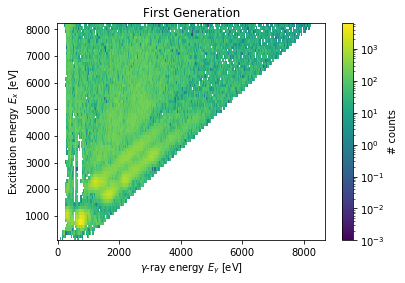

In [4]:
firstgen = om.first_generation_method(unfolded, Ex_max=8500, dE_gamma=500)
firstgen.plot(zmin=1e-3)

In [ ]:
# Do error propagation in order to obtain an error matrix on the first generation spectrum
# Note that it requires an instance of MatrixAnalysis as input
logger = logging.getLogger("ompy.ensemble")
logger.setLevel(logging.INFO)

unfolder = om.Unfolder()
unfolder.cut_diagonal((800, 0), (7500, 7300))
unfolder.load_response(fname_resp_mat)
unfolded = unfolder.unfold(raw)

def firstmethod(U):
    return om.first_generation_method(matrix_in=U, Ex_max=8500,
                                     dE_gamma=800,multiplicity_estimation="statistical")

ensemble = om.Ensemble(raw=raw)
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstmethod
ensemble.generate(number=10, regenerate=True)


INFO:ompy.ensemble:Generating raw ensemble 0
INFO:ompy.ensemble:Unfolding raw 0
  fluctuations /= self.fluctuations(self.r)

INFO:ompy.ensemble:Performing first generation on unfolded 0
INFO:ompy.ensemble:Generating raw ensemble 1
INFO:ompy.ensemble:Unfolding raw 1
INFO:ompy.ensemble:Performing first generation on unfolded 1
INFO:ompy.ensemble:Generating raw ensemble 2
INFO:ompy.ensemble:Unfolding raw 2
INFO:ompy.ensemble:Performing first generation on unfolded 2
INFO:ompy.ensemble:Generating raw ensemble 3
INFO:ompy.ensemble:Unfolding raw 3
INFO:ompy.ensemble:Performing first generation on unfolded 3
INFO:ompy.ensemble:Generating raw ensemble 4
INFO:ompy.ensemble:Unfolding raw 4
INFO:ompy.ensemble:Performing first generation on unfolded 4
INFO:ompy.ensemble:Generating raw ensemble 5
INFO:ompy.ensemble:Unfolding raw 5
INFO:ompy.ensemble:Performing first generation on unfolded 5
INFO:ompy.ensemble:Generating raw ensemble 6
INFO:ompy.ensemble:Unfolding raw 6
INFO:ompy.ensemble:Performing

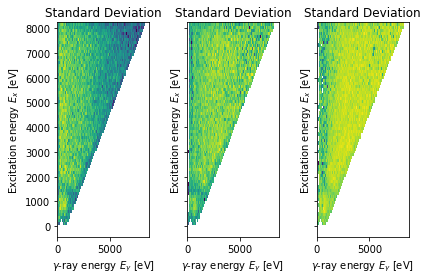

In [ ]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ensemble.std_raw.plot(ax=ax[0])
ensemble.std_unfolded.plot(ax=ax[1])
ensemble.std_firstgen.plot(ax=ax[2])
plt.tight_layout()
plt.show()

In [ ]:
# Decomposition with the new 1Gen matrixes -- if saved, just load them again

bin_width_out = 150
Ex_min = 4000
Ex_max = 8000
Eg_min = 1000

ftol = 1e-4 # Fitting tolerance (in some unknown, relative units)
maxfev = 9000 # maximum number of function evaluations

N_fits = 10

rho_ens = []
gsf_ens = []
try:
    nld_Earray = np.loadtxt("error_propagation_ensemble/rho_E_array.txt")
    gsf_Earray = np.loadtxt("error_propagation_ensemble/gsf_E_array.txt")
    for i in range(N_fits):
        rho_val = np.loadtxt("error_propagation_ensemble/rho_ensemble_fits-{:d}.txt".format(i))
        gsf_val = np.loadtxt("error_propagation_ensemble/gsf_ensemble_fits-{:d}.txt".format(i))
        rho = om.Vector(rho_val, nld_Earray)
        rho_ens.append(rho)
        gsf = om.Vector(gsf_val, gsf_Earray)
        gsf_ens.append(gsf)
except:
    std = ensemble.std_firstgen
    #std = om.Matrix()
    #std.load("Dy164/error_propagation_ensemble/firstgen_std.m")
    for i in range(N_fits):
        print("Start of iteration {}".format(i))
        #base = "Dy164/error_propagation_ensemble/firstgen-{:d}.m"
        #mat = om.Matrix()
        #mat.load(base.format(i))
        #mat.values[mat.values < 0] = 0
        mat = om.Matrix(ensemble.firstgen_ensemble[i],
                     Ex=std.Ex,
                     Eg=std.Eg)
        fits = om.FitRhoT(mat, std, bin_width_out,
                              Ex_min, Ex_max, Eg_min,
                              method="Powell",
                              options={'disp':True, 'ftol':ftol, 'maxfev':maxfev}
                              #error_normalization="approximate"
                             )
        rho_ens.append(fits.rho)
        T = fits.T
        gsf = T.values / (2 * np.pi * (T.E_array)**3)
        gsf_ens.append(om.Vector(gsf,T.E_array))

        np.savetxt("error_propagation_ensemble/rho_ensemble_fits-{:d}.txt".format(i), rho_ens[i].values)
        np.savetxt("error_propagation_ensemble/gsf_ensemble_fits-{:d}.txt".format(i), gsf_ens[i].values)

    np.savetxt("error_propagation_ensemble/rho_E_array.txt", rho_ens[0].E_array)
    np.savetxt("error_propagation_ensemble/gsf_E_array.txt", gsf_ens[0].E_array)

rho_ens_initial = rho_ens
gsf_ens_initial = gsf_ens

Start of iteration 0
attempt decomposition
Optimization terminated successfully.
         Current function value: 101073.609375
         Iterations: 6
         Function evaluations: 8985
Start of iteration 1
attempt decomposition
Start of iteration 2
attempt decomposition
Start of iteration 3
attempt decomposition
Start of iteration 4
attempt decomposition


In [ ]:
# Again, but this time loading the original 1Gen matrixes from jørgen
rho_ens = []
gsf_ens = []
try:
    nld_Earray = np.loadtxt("error_propagation_ensemble/rho_orig_E_array.txt")
    gsf_Earray = np.loadtxt("error_propagation_ensemble/gsf_orig_E_array.txt")
    for i in range(N_fits):
        rho_val = np.loadtxt("error_propagation_ensemble/rho_orig_ensemble_fits-{:d}.txt".format(i))
        gsf_val = np.loadtxt("error_propagation_ensemble/gsf_orig_ensemble_fits-{:d}.txt".format(i))
        rho = om.Vector(rho_val, nld_Earray)
        rho_ens.append(rho)
        gsf = om.Vector(gsf_val, gsf_Earray)
        gsf_ens.append(gsf)
except:
    #std = ensemble.std_firstgen
    std = om.Matrix()
    std.load("Dy164/error_propagation_ensemble/firstgen_std.m")
    for i in range(N_fits):
        print("Start of iteration {}".format(i))
        base = "Dy164/error_propagation_ensemble/firstgen-{:d}.m"
        mat = om.Matrix()
        mat.load(base.format(i))
        mat.values[mat.values < 0] = 0
        #mat = om.Matrix(ensemble.firstgen_ensemble[i],
        #             Ex=std.Ex,
        #             Eg=std.Eg)
        fits = om.FitRhoT(mat, std, bin_width_out,
                              Ex_min, Ex_max, Eg_min,
                              method="Powell",
                              options={'disp':True, 'ftol':ftol, 'maxfev':maxfev}
                              #error_normalization="approximate"
                             )
        rho_ens.append(fits.rho)
        T = fits.T
        gsf = T.values / (2 * np.pi * (T.E_array)**3)
        gsf_ens.append(om.Vector(gsf,T.E_array))

        np.savetxt("error_propagation_ensemble/rho_orig_ensemble_fits-{:d}.txt".format(i), rho_ens[i].values)
        np.savetxt("error_propagation_ensemble/gsf_orig_ensemble_fits-{:d}.txt".format(i), gsf_ens[i].values)

    np.savetxt("error_propagation_ensemble/rho_orig_E_array.txt", rho_ens[0].E_array)
    np.savetxt("error_propagation_ensemble/gsf_orig_E_array.txt", gsf_ens[0].E_array)

rho_ens_orig = rho_ens
gsf_ens_orig = gsf_ens

In [ ]:
## Load ensemble members of rho and T fits
#rho_orig = np.loadtxt("Dy164/error_propagation_ensemble/#rho_ensemble_fits-{:d}.txt".format(10))
#T_orig = np.loadtxt("Dy164/error_propagation_ensemble/#T_ensemble_fits-{:d}.txt".format(10))
#gsf_orig = np.copy(T_orig)
#for i in range(10):
#    gsf_orig[i] = T_orig[i]/(2*np.pi*gsf_ens_initial[0].E_array**3)
#"""
#rho_orig_ens = []
#gsf_orig_ens = []
#for i in range(10):
#    E_array = rho_ens_initial[0].E_array
#    om.Vector(rho_orig[i],E_array)
#"""
#rho_orig_mean = np.mean(rho_orig, axis=0)
#gsf_orig_mean = np.mean(gsf_orig, axis=0)
#
#rho_orig_std = np.std(rho_orig, axis=0)
#gsf_orig_std = np.std(gsf_orig, axis=0)
#print(rho_orig_std/rho_orig_mean)
#
#fig, (ax1,ax2) = plt.subplots(1,2) 
#ax1.set_yscale("log")
#ax2.set_yscale("log")
#for i in range(10):
#    ax1.plot(range(len(rho_orig[i,:])), rho_orig[i,:], "-", label=str(i))
#    ax2.plot(range(len(gsf_orig[i,:])), gsf_orig[i,:], "-")
#    

In [ ]:
def plot_nld_gsf(rho_ens, gsf_ens):
    fig, (ax1,ax2) = plt.subplots(1,2) 
    for i in range(10):
        ax1.plot(rho_ens[i].E_array, rho_ens[i].values, "-", label=str(i))
        ax2.plot(gsf_ens[i].E_array, gsf_ens[i].values, "-")
    ax1.set_yscale("log")
    ax1.legend()
    ax2.set_yscale("log")
    plt.plot()
    
plot_nld_gsf(rho_ens_initial, gsf_ens_initial)
plot_nld_gsf(rho_ens_orig, gsf_ens_orig)

In [ ]:
# load the chi-by-eye guessed extrapolation and the discrete levels
nld_ext = np.array([[6000.,  116.26215326],
 [6040.81632653,  125.20610283],
 [6081.63265306,  134.83810291],
 [6122.44897959,  145.21108465],
 [6163.26530612,  156.38205113],
 [6204.08163265,  168.41239067],
 [6244.89795918,  181.36821409],
 [6285.71428571,  195.32071811],
 [6326.53061224,  210.34657651],
 [6367.34693878,  226.52836155],
 [6408.16326531,  243.95499769],
 [6448.97959184,  262.72225027],
 [6489.79591837,  282.9332518 ],
 [6530.6122449 ,  304.69906865],
 [6571.42857143,  328.13931147],
 [6612.24489796,  353.38279244],
 [6653.06122449,  380.56823315],
 [6693.87755102,  409.84502692],
 [6734.69387755,  441.37405979],
 [6775.51020408,  475.32859461],
 [6816.32653061,  511.89522321],
 [6857.14285714,  551.27489177],
 [6897.95918367,  593.68400507],
 [6938.7755102 ,  639.35561575],
 [6979.59183673,  688.54070499],
 [7020.40816327,  741.50956173],
 [7061.2244898 ,  798.55326803],
 [7102.04081633,  859.98529863],
 [7142.85714286,  926.14324363],
 [7183.67346939,  997.39066363],
 [7224.48979592, 1074.11908767],
 [7265.30612245, 1156.75016478],
 [7306.12244898, 1245.73798107],
 [7346.93877551, 1341.57155516],
 [7387.75510204, 1444.77752542],
 [7428.57142857, 1555.92304407],
 [7469.3877551 , 1675.61889391],
 [7510.20408163, 1804.5228447 ],
 [7551.02040816, 1943.3432679 ],
 [7591.83673469, 2092.84302938],
 [7632.65306122, 2253.84368164],
 [7673.46938776, 2427.22997854],
 [7714.28571429, 2613.95473728],
 [7755.10204082, 2815.04407451],
 [7795.91836735, 3031.60304514],
 [7836.73469388, 3264.82171507],
 [7877.55102041, 3515.98170093],
 [7918.36734694, 3786.46321304],
 [7959.18367347, 4077.75264016],
 [8000.        , 4391.45071767]])

discretes = np.array([[9.38055627e+02, 1.72174984e-02],
 [1.08805563e+03, 2.39435633e-02],
 [1.23805563e+03, 2.39891464e-02],
 [1.38805563e+03, 1.89126141e-02],
 [1.53805563e+03, 3.08627228e-02],
 [1.68805563e+03, 5.60265862e-02],
 [1.83805563e+03, 7.43165369e-02]])

In [ ]:
# plot initial rho and gsf
rho_mean = np.mean([vec.values for vec in rho_ens_initial], axis=0)
gsf_mean = np.mean([vec.values for vec in gsf_ens_initial], axis=0)

rho_std = np.std([vec.values for vec in rho_ens_initial], axis=0)
gsf_std = np.std([vec.values for vec in gsf_ens_initial], axis=0)
print(rho_std/rho_mean)

fig, (ax1,ax2) = plt.subplots(1,2) 
ax1.errorbar(rho_ens[0].E_array, rho_mean, yerr=rho_std, fmt="o")
ax2.errorbar(gsf_ens[0].E_array, gsf_mean, yerr=gsf_std, fmt="o")

In [ ]:
# just giving it a try
alpha = 0.0023
const = 0.02*1e-3

#alpha = 9.99999393e-05
#const = 4.99994376e-03

rho_ens = [vec.transform(alpha=alpha, const=const) for vec in rho_ens_initial]
gsf_ens = [vec.transform(alpha=alpha) for vec in gsf_ens_initial]

#nld, nld_std = transform_with_std(rho_ens[0].E_array, rho_mean, rho_std, const=0.02*1e-3)
#gsf, gsf_std = transform_with_std(gsf_ens[0].E_array, gsf_mean, gsf_std)

rho_mean = np.mean([vec.values for vec in rho_ens], axis=0)
gsf_mean = np.mean([vec.values for vec in gsf_ens], axis=0)

rho_std = np.std([vec.values for vec in rho_ens], axis=0)
gsf_std = np.std([vec.values for vec in gsf_ens], axis=0)
print(rho_std/rho_mean)

yscale ="log"
fig, (ax1,ax2) = plt.subplots(1,2) 
ax1.errorbar(rho_ens[0].E_array, rho_mean, yerr=rho_std, fmt="o")
ax2.errorbar(gsf_ens[0].E_array, gsf_mean, yerr=gsf_std, fmt="o")
ax1.set_yscale(yscale)
ax2.set_yscale(yscale)

try:
    ax1.plot(nld_ext[:,0],nld_ext[:,1])
    ax1.plot(discretes[:,0],discretes[:,1])
except:
    pass

# Load and add published, normalized data:
rho_published = np.loadtxt("Dy164/data/rho164dy.txt", skiprows=2)
rho_published[:, 1] *= 1000
ax1.errorbar(rho_published[:, 1], rho_published[:, 2], yerr=rho_published[:, 3],
                      fmt="<", markersize=2, color="crimson",
                      label=r"$\rho$, Nyhus $\textit{et\,\,al.}$")

In [ ]:
# find_norm

pnld_norm = {}
pnld_norm["E1_low"] = 1e3
pnld_norm["E2_low"] = 2.e3
pnld_norm["E1_high"] = 3.5e3
pnld_norm["E2_high"] = 6.5e3
pnld_norm["nld_Sn"] = np.array([7.658e3,2.36e6*1e-3])
pnld_ext = {} # automatically found for CT
pnld_ext["ext_range"] = np.array([6e3,8e3]) # extrapolation range
fname_discretes = "Dy164/data/discrete_levels.txt"

rho_initial_mean = np.mean([vec.values for vec in rho_ens_initial], axis=0)
rho_initial_std = np.std([vec.values for vec in rho_ens_initial], axis=0)
rho_initial_std = np.ones(len(rho_initial_mean))
nld = np.c_[rho_ens_initial[i].E_array, rho_initial_mean, rho_initial_std]

print("Uncs:", nld[:,2]/nld[:,1])

normNLD = om.NormNLD(nld=nld,
                       method="find_norm", pnorm=pnld_norm,
                       nldModel="CT", pext=pnld_ext,
                       fname_discretes=fname_discretes )

rho_fit = normNLD.nld_norm
nld_ext = normNLD.nld_ext
A_norm = normNLD.A_norm
alpha_norm = normNLD.alpha_norm
discretes = normNLD.discretes


In [ ]:
print(normNLD.pext)
print("Uncs:", rho_fit[:,2]/rho_fit[:,1])
yscale ="log"
fig, (ax1,ax2) = plt.subplots(1,2) 
ax1.errorbar(rho_fit[:,0],rho_fit[:,1],yerr=rho_fit[:,2],fmt="o")
ax1.plot(nld_ext[:,0],nld_ext[:,1],"--")
ax1.plot(discretes[:,0],discretes[:,1],"-")
ax1.set_yscale(yscale)
print(discretes)

In [ ]:
yscale